<a href="https://colab.research.google.com/github/xVILENx/Dengue_SINAN/blob/main/dengue_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

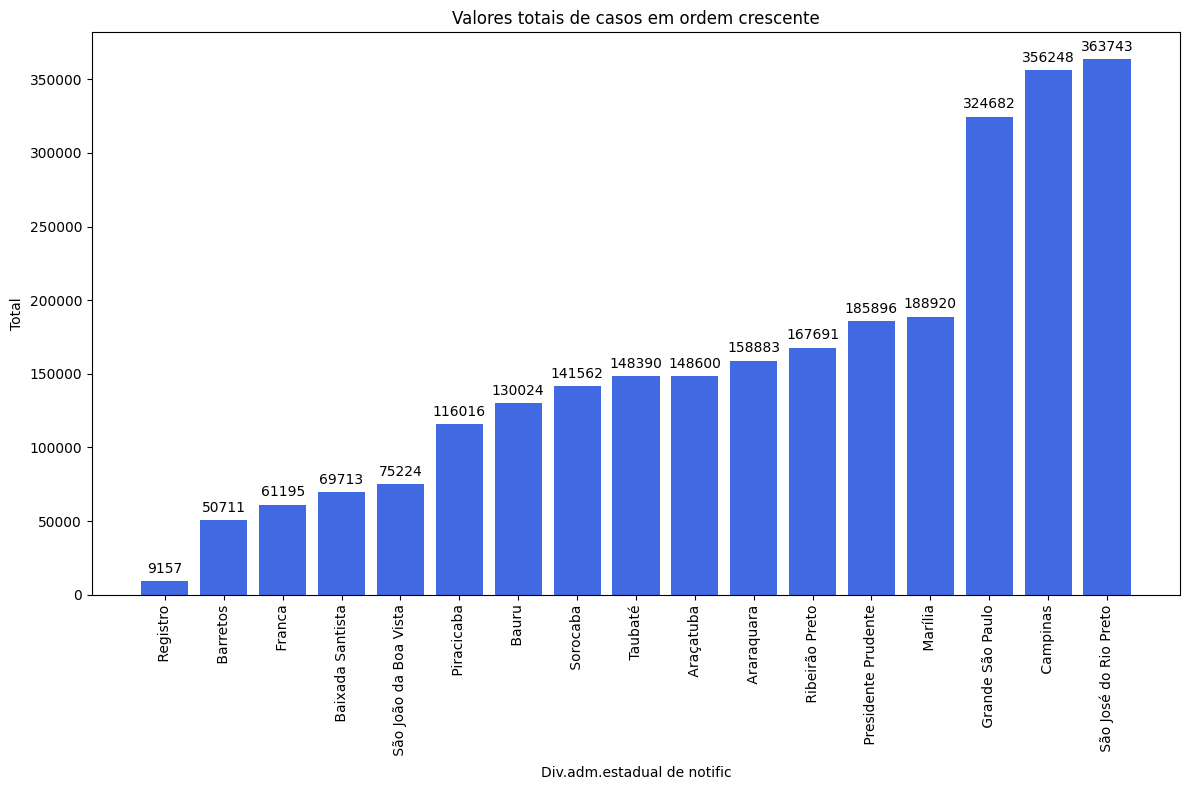

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Função para remover números de uma string
def remover_numeros(texto):
    return re.sub(r'\d+', '', texto)

# Ler o arquivo CSV
dados = pd.read_csv('/content/Dengue_SINAN - casos.csv')

# Remover números da coluna "Div.adm.estadual de notific"
dados['Div.adm.estadual de notific'] = dados['Div.adm.estadual de notific'].apply(remover_numeros)

# Ordenar os valores da coluna "Total" em ordem crescente
dados = dados.sort_values(by='Total')

# Descartar o maior valor
dados = dados.iloc[:-1]

# Plotar gráfico de barras
plt.figure(figsize=(12, 8))
bars = plt.bar(dados['Div.adm.estadual de notific'], dados['Total'], color='royalblue')

# Tamanho da fonte dos valores
tamanho_fonte = 10  # Ajuste o tamanho da fonte aqui

# Adicionar valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + (max(dados['Total']) * 0.01),
             str(height), ha='center', va='bottom', fontsize=tamanho_fonte)

# Adicionar título e rótulos dos eixos
plt.title('Valores totais de casos em ordem crescente')
plt.xlabel('Div.adm.estadual de notific')
plt.ylabel('Total')
plt.xticks(rotation=90)

# Remover a grade
plt.grid(False)

plt.tight_layout()
plt.show()


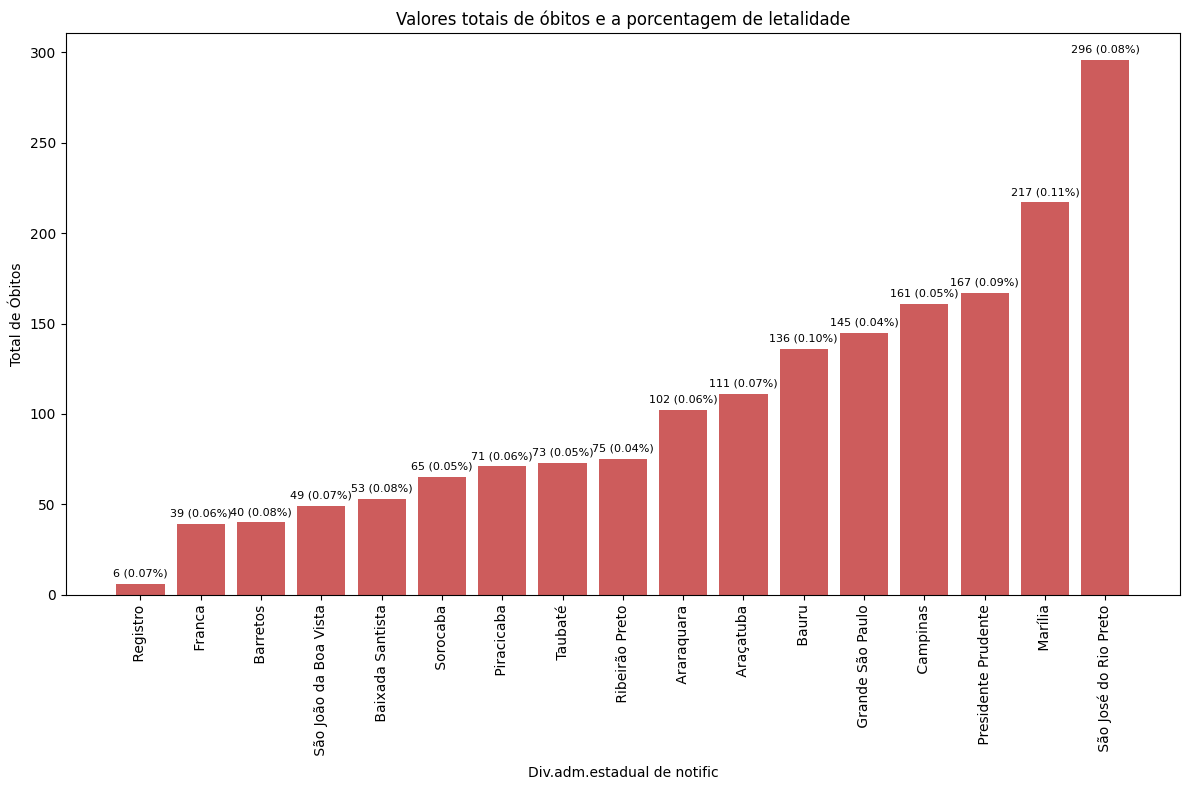

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Função para remover números de uma string
def remover_numeros(texto):
    return re.sub(r'\d+', '', texto)

# Ler os arquivos CSV
dados_obitos = pd.read_csv('/content/Dengue_SINAN - obitos.csv')
dados_casos = pd.read_csv('/content/Dengue_SINAN - casos.csv')

# Remover números da coluna "Div.adm.estadual de notific"
dados_obitos['Div.adm.estadual de notific'] = dados_obitos['Div.adm.estadual de notific'].apply(remover_numeros)
dados_casos['Div.adm.estadual de notific'] = dados_casos['Div.adm.estadual de notific'].apply(remover_numeros)

# Combinar os DataFrames com base na coluna 'Div.adm.estadual de notific'
dados = pd.merge(dados_obitos[['Div.adm.estadual de notific', 'Total']],
                 dados_casos[['Div.adm.estadual de notific', 'Total']],
                 on='Div.adm.estadual de notific',
                 suffixes=('_obitos', '_casos'))

# Calcular a letalidade (óbitos / casos) * 100 para obter a porcentagem
dados['Letalidade (%)'] = (dados['Total_obitos'] / dados['Total_casos']) * 100

# Ordenar os valores da coluna "Total_obitos" em ordem crescente
dados = dados.sort_values(by='Total_obitos')

# Descartar o maior valor de óbitos (se necessário)
dados = dados.iloc[:-1]

# Plotar gráfico de barras
plt.figure(figsize=(12, 8))
bars = plt.bar(dados['Div.adm.estadual de notific'], dados['Total_obitos'], color='indianred')

# Tamanho da fonte dos valores
tamanho_fonte = 8  # Ajuste o tamanho da fonte aqui

# Adicionar valores e porcentagens de letalidade no topo das barras
for i, (bar, letalidade) in enumerate(zip(bars, dados['Letalidade (%)'])):
    height = bar.get_height()
    texto_exibido = f"{height} ({letalidade:.2f}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, height + (max(dados['Total_obitos']) * 0.01),
             texto_exibido, ha='center', va='bottom', fontsize=tamanho_fonte)

# Adicionar título e rótulos dos eixos
plt.title('Valores totais de óbitos e a porcentagem de letalidade')
plt.xlabel('Div.adm.estadual de notific')
plt.ylabel('Total de Óbitos')
plt.xticks(rotation=90)

# Remover a grade
plt.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import folium
import numpy as np
import branca

# Função para normalizar os valores (escala de 0 a 1)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Carregar os dados dos CSVs
df_casos = pd.read_csv('/content/Dengue_SINAN - casos.csv')
df_obitos = pd.read_csv('/content/Dengue_SINAN - obitos.csv')

# Remover a linha 'Total' (assumindo que a linha 19 tenha índice 18)
df_casos = df_casos.drop(index=17)
df_obitos = df_obitos.drop(index=17)

# Remover os números antes dos nomes das divisões administrativas
df_casos['Div.adm.estadual de notific'] = df_casos['Div.adm.estadual de notific'].apply(lambda x: x.split(' ', 1)[1])
df_obitos['Div.adm.estadual de notific'] = df_obitos['Div.adm.estadual de notific'].apply(lambda x: x.split(' ', 1)[1])

# Mapear as divisões administrativas para suas coordenadas (latitude e longitude)
coordenadas = {
    'Grande São Paulo': [-23.5505, -46.6333],
    'Araçatuba': [-21.2076, -50.4372],
    'Araraquara': [-21.7944, -48.1756],
    'Baixada Santista': [-23.9675, -46.3297],
    'Barretos': [-20.5531, -48.5698],
    'Bauru': [-22.3145, -49.0582],
    'Campinas': [-22.9053, -47.0659],
    'Franca': [-20.5386, -47.4009],
    'Marília': [-22.2171, -49.9501],
    'Piracicaba': [-22.7338, -47.6476],
    'Presidente Prudente': [-22.1207, -51.3939],
    'Registro': [-24.4878, -47.8434],
    'Ribeirão Preto': [-21.1775, -47.8103],
    'São João da Boa Vista': [-21.9697, -46.7987],
    'São José do Rio Preto': [-20.8202, -49.3797],
    'Sorocaba': [-23.5015, -47.4526],
    'Taubaté': [-23.0264, -45.5551]
}

# Adicionar colunas de latitude e longitude aos dataframes
df_casos['Latitude'] = df_casos['Div.adm.estadual de notific'].map(lambda x: coordenadas[x][0])
df_casos['Longitude'] = df_casos['Div.adm.estadual de notific'].map(lambda x: coordenadas[x][1])
df_obitos['Latitude'] = df_obitos['Div.adm.estadual de notific'].map(lambda x: coordenadas[x][0])
df_obitos['Longitude'] = df_obitos['Div.adm.estadual de notific'].map(lambda x: coordenadas[x][1])

# Normalizar os dados para escala de cor
df_casos['Total_normalized'] = normalize(df_casos['Total'])
df_obitos['Total_normalized'] = normalize(df_obitos['Total'])

# Criar um mapa centrado em São Paulo
mapa = folium.Map(location=[-23.5505, -46.6333], zoom_start=7)

# Adicionar círculos ao mapa para "casos"
for _, row in df_casos.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=50,  # Tamanho dos círculos
         color=branca.colormap.LinearColormap(colors=['blue', 'green'])(row['Total_normalized']),
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['Div.adm.estadual de notific']}: {row['Total']} casos"
    ).add_to(mapa)

# Adicionar círculos ao mapa para "óbitos"
for _, row in df_obitos.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=30,  # Tamanho dos círculos
         color=branca.colormap.LinearColormap(colors=['yellow', 'red'])(row['Total_normalized']),
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['Div.adm.estadual de notific']}: {row['Total']} óbitos"
    ).add_to(mapa)

# Adicionar uma legenda personalizada
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 300px; height: 120px;
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; padding: 10px;">
     <b>Legenda:</b><br>
     <span style="display:inline-block; width:12px; height:12px; background-color: blue; margin-right: 5px;"></span>
     <span style="display:inline-block; width:12px; height:12px; background-color: green; margin-right: 5px;"></span>
     Casos [azul (🠗 casos) - verde (🠕 casos)]<br>
     <span style="display:inline-block; width:12px; height:12px; background-color: yellow; margin-right: 5px;"></span>
     <span style="display:inline-block; width:12px; height:12px; background-color: red; margin-right: 5px;"></span>
     Óbitos [amarelo (🠗 óbitos) - vermelho (🠕 óbitos)]
</div>
'''

mapa.get_root().html.add_child(folium.Element(legend_html))

# Salvar o mapa em um arquivo HTML
mapa.save("mapa_calor_casos_obitos.html")


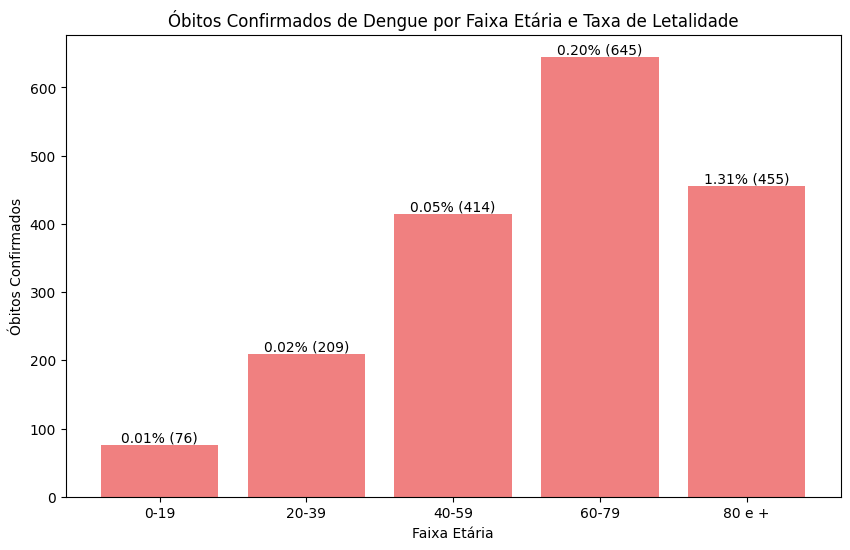

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import gspread
from google.colab import auth
from google.auth import default

# Autenticar no Google
auth.authenticate_user()
creds, _ = default()

# Autorizar o acesso à planilha com as credenciais obtidas
gc = gspread.authorize(creds)

# Substitua com o ID da sua planilha do Google Sheets
spreadsheet_id = '1_9RDRSbd5Uo__vNQz5yKVoyumJtk7qTN_F3AVmLTEbs'

# Abrir a planilha usando o ID
spreadsheet = gc.open_by_key(spreadsheet_id)

# Ler a página "casos_simples"
worksheet_casos = spreadsheet.worksheet('casos_simples')

# Extrair dados de faixa etária e casos confirmados
faixa_etaria = worksheet_casos.row_values(1)[1:6]  # B1 até F1
casos_confirmados = worksheet_casos.row_values(12)[1:6]  # B12 até F12
casos_confirmados = list(map(int, casos_confirmados))  # Converter para inteiros

# Ler a página "obitos_simples"
worksheet_obitos = spreadsheet.worksheet('obitos_simples')

# Extrair dados de óbitos confirmados
obitos_confirmados = worksheet_obitos.row_values(12)[1:6]  # B12 até F12
obitos_confirmados = list(map(int, obitos_confirmados))  # Converter para inteiros

# Calcular a taxa de letalidade
taxa_letalidade = [obitos * 100 / casos if casos > 0 else 0 for obitos, casos in zip(obitos_confirmados, casos_confirmados)]

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(faixa_etaria, obitos_confirmados, color='lightcoral')
plt.xlabel('Faixa Etária')
plt.ylabel('Óbitos Confirmados')
plt.title('Óbitos Confirmados de Dengue por Faixa Etária e Taxa de Letalidade')

# Configurar o formato dos rótulos do eixo y para exibir números inteiros
plt.ticklabel_format(style='plain', axis='y')

# Adicionar os valores no topo de cada barra com taxa de letalidade e óbitos entre parênteses
for bar, taxa, obitos in zip(bars, taxa_letalidade, obitos_confirmados):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{taxa:.2f}% ({obitos})', ha='center', va='bottom')

plt.show()


<Figure size 2000x800 with 0 Axes>

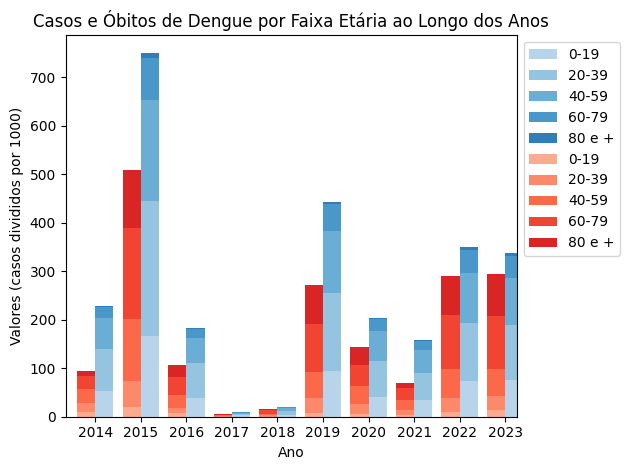

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gspread
from google.colab import auth
from google.auth import default

# Autenticar no Google
auth.authenticate_user()
creds, _ = default()

# Autorizar o acesso à planilha com as credenciais obtidas
gc = gspread.authorize(creds)

# Substitua com o ID da sua planilha do Google Sheets
spreadsheet_id = '1_9RDRSbd5Uo__vNQz5yKVoyumJtk7qTN_F3AVmLTEbs'

# Abrir a planilha usando o ID
spreadsheet = gc.open_by_key(spreadsheet_id)

# Ler a página "casos_simples"
worksheet_casos = spreadsheet.worksheet('casos_simples')

# Extrair dados
faixa_etaria = worksheet_casos.row_values(1)[1:6]  # B1 até F1 (5 faixas etárias)
anos_casos = worksheet_casos.col_values(1)[1:11]  # A2 até A11 (10 anos)
casos_por_faixa_etaria = worksheet_casos.get_values('B2:F11')  # Dados de B2:F11

# Converter os dados para inteiros
casos_por_faixa_etaria = [[int(caso) if caso else 0 for caso in linha] for linha in casos_por_faixa_etaria]

# Criar DataFrame com o número de faixas etárias e anos corretos
df_casos = pd.DataFrame(casos_por_faixa_etaria, columns=faixa_etaria, index=anos_casos)

# Dividir os valores de casos por 1000
df_casos_dividido = df_casos / 1000

# Ler a página "obitos_simples"
worksheet_obitos = spreadsheet.worksheet('obitos_simples')

# Extrair dados
faixa_etaria_obitos = worksheet_obitos.row_values(1)[1:6]  # B1 até F1 (5 faixas etárias)
anos_obitos = worksheet_obitos.col_values(1)[1:11]  # A2 até A11 (10 anos)
obitos_por_faixa_etaria = worksheet_obitos.get_values('B2:F11')  # Dados de B2:F11

# Converter os dados para inteiros
obitos_por_faixa_etaria = [[int(obito) if obito else 0 for obito in linha] for linha in obitos_por_faixa_etaria]

# Criar DataFrame com o número de faixas etárias e anos corretos
df_obitos = pd.DataFrame(obitos_por_faixa_etaria, columns=faixa_etaria_obitos, index=anos_obitos)

# Encontrar o maior valor e a faixa etária correspondente para casos
max_casos = df_casos_dividido.max().max()
faixa_max_casos = df_casos_dividido.stack().idxmax()

# Encontrar o maior valor e a faixa etária correspondente para óbitos
max_obitos = df_obitos.max().max()
faixa_max_obitos = df_obitos.stack().idxmax()

# Configurar o gráfico
plt.figure(figsize=(20, 8))

# Plotar colunas empilhadas para casos
ax = df_casos_dividido.plot(kind='bar', stacked=True, color=plt.cm.Blues(np.linspace(0.3, 0.7, len(df_casos_dividido.columns))),
                           edgecolor='none', position=0, width=0.4, label='Casos')

# Plotar colunas empilhadas para óbitos
df_obitos.plot(kind='bar', stacked=True, color=plt.cm.Reds(np.linspace(0.3, 0.7, len(df_obitos.columns))),
               edgecolor='none', position=1, width=0.4, ax=ax, label='Óbitos')


# Configurar o gráfico
plt.xlabel('Ano')
plt.ylabel('Valores (casos divididos por 1000)')
plt.title('Casos e Óbitos de Dengue por Faixa Etária ao Longo dos Anos')
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)  # Remover a grade

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()